# Tutorial 05

## fore-/back-ground models

following 

Planck 2018 results. XI. Polarized dust foregrounds
https://doi.org/10.1051/0004-6361/201832618

and

Polarized galactic synchrotron and dust emission and their correlation
https://doi.org/10.1088/1475-7516/2015/12/020

#### frequency scaling

this would use the `bandpower` function, which takes a frequency list (in GHz) as input,
the return gives an array in shape 
```
(angular mode size, frequency size, frequency size)
```

- synchrotron

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_s} br(\nu_1,\nu_0)br(\nu_2,\nu_0)$$

$$ br(\nu,\nu_0) = \left(\frac{\nu_0}{\nu}\right)^4 e^{(x_0-x)} \left(\frac{e^x-1}{e^{x_0}-1}\right)^2 $$

$$ x(\nu) = \frac{h\nu}{k_\mathrm{B} T_0}, T_0 \approx 2.73 \mathrm{K}$$

with Planck reference, $\nu_0 = 30$ GHz, the function $br(\nu,\nu_0)$ originated from converting emission brightness into CMB thermal temperature.

- thermal dust

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_d} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} br(\nu_1,\nu_0)br(\nu_2,\nu_0)$$

with Planck reference, we take $\nu_0=353$ GHz, $T_d = 19.6$ K.

- synchrotron-dust

$$ \frac{\mathcal{D}^{XX}_\ell(\nu_1,\nu_2)}{br(\nu_1,\nu_0)br(\nu_2,\nu_0)} = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0s}} \right)^{\beta_s} + \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0d}} \right)^{\beta_d} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + \rho^{XX} \sqrt{\mathcal{A}^{XX}_{s,\ell}\mathcal{A}^{XX}_{d,\ell}} \left( (\frac{\nu_1}{\nu_{0s}})^{\beta_s}(\frac{\nu_2}{\nu_{0d}})^{\beta_d}\frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + (\frac{\nu_2}{\nu_{0s}})^{\beta_s}(\frac{\nu_1}{\nu_{0d}})^{\beta_d}\frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)}\right)$$

with Planck reference, $\nu_{0s} = 30$ GHz, $\nu_{0d} = 353$ GHz.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

map23f = hp.smoothing(map23f,fwhm=FWHM[0],verbose=0)
map95f = hp.smoothing(map95f,fwhm=FWHM[1],verbose=0)
map150f = hp.smoothing(map150f,fwhm=FWHM[2],verbose=0)
map353f = hp.smoothing(map353f,fwhm=FWHM[3],verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### synchrotron model

- T mode, templated

{23: array([[29.76796444, 12.86444705, 12.55816553, 12.04505941, 13.03900691,
        13.80874594, 12.9905605 ]])}
{'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

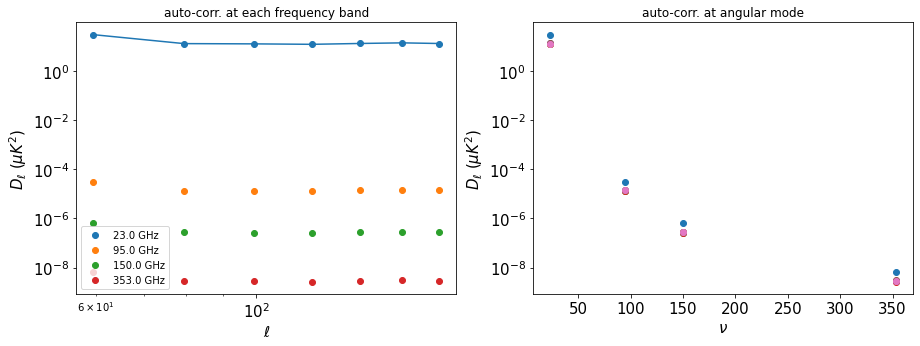

In [2]:
from afra.tools.fg_models import asyncmodel, tsyncmodel

FREQS = [23.,95.,150.,353.]
TARGET = 'T'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,targets=TARGET)
fullps = {23: est.autoBP(map23f,fwhms=FWHM[0])[1].reshape(1,-1)}

s = tsyncmodel(freqlist=FREQS,estimator=est,template_ps=fullps)
s.reset({'beta_s':-3.})
print (s._template_ps)
bp = s.bandpower()[0]
print (s.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(est.modes,fullps[23][0])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

#fig,ax = plt.subplots(212,figsize=(5,5))

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

- T mode, modeled

{'A_sT': 2000.0, 'alpha_s': -2.0, 'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

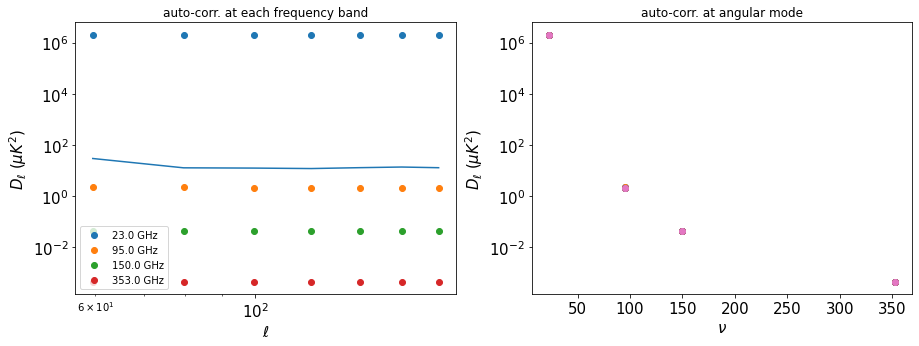

In [3]:
s = asyncmodel(freqlist=FREQS,estimator=est)
s.reset({'A_sT':2000.})
s.reset({'alpha_s':-2.})
s.reset({'beta_s':-3.})
bp = s.bandpower()[0]
print (s.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[23][0])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

- E & B modes, templated

{'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

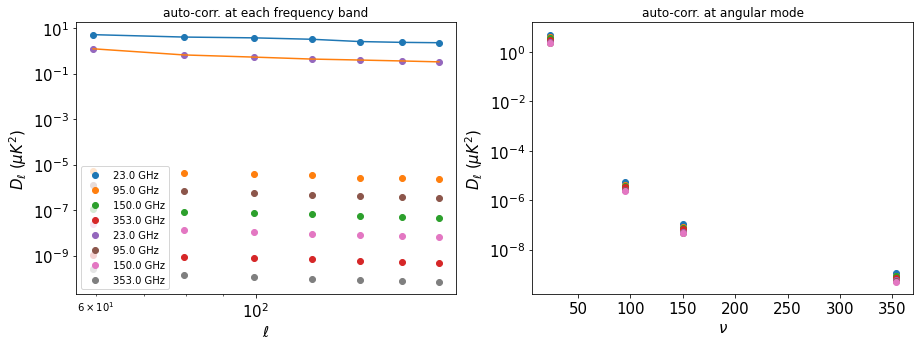

In [4]:
est.targets = 'EB'

fullps = {23:np.array(est.autoBP(map23f,fwhms=FWHM[0])[1:3]).reshape(2,-1)}

s = tsyncmodel(freqlist=FREQS,estimator=est,template_ps=fullps)
s.reset({'beta_s':-3.})
bp = s.bandpower()
print (s.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[23][0])
ax[0].plot(est.modes,fullps[23][1])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

E & B modes, modeled

{'A_sE': 2000.0, 'A_sB': 1000.0, 'alpha_s': -3.0, 'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

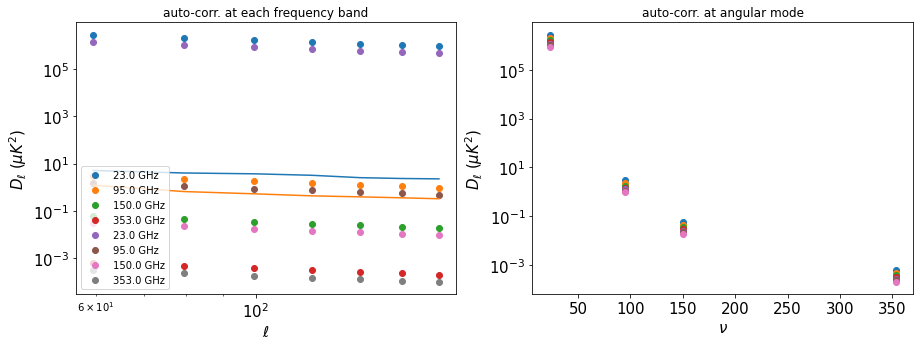

In [5]:
s = asyncmodel(freqlist=FREQS,estimator=est)
s.reset({'A_sE':2000.})
s.reset({'A_sB':1000.})
s.reset({'alpha_s':-3.})
s.reset({'beta_s':-3.})
bp = s.bandpower()
print (s.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[23][0])
ax[0].plot(est.modes,fullps[23][1])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))

ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

#### thermal dust model

- T mode, templated

{'beta_d': 1.5}


Text(0.5, 1.0, 'auto-corr. at angular mode')

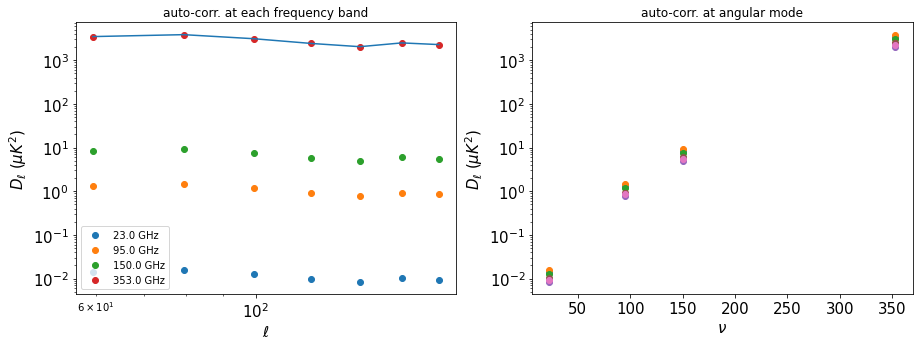

In [6]:
from afra.tools.fg_models import adustmodel, tdustmodel

est.targets = 'T'

fullps = {353:est.autoBP(map353f,fwhms=FWHM[3])[1].reshape(1,-1)}

d = tdustmodel(freqlist=FREQS,estimator=est,template_ps=fullps)

d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[353][0])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

T mode, modeled

{'A_dT': 2000, 'alpha_d': 1.0, 'beta_d': 1.5}


Text(0.5, 1.0, 'auto-corr. at angular mode')

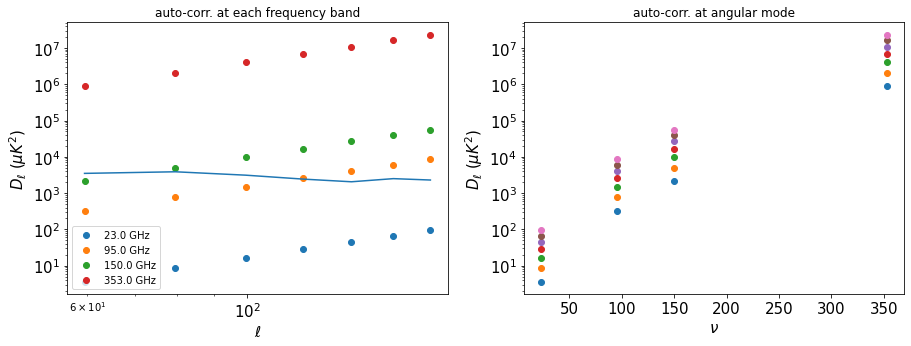

In [7]:
d = adustmodel(freqlist=FREQS,estimator=est)
d.reset({'A_dT':2000})
d.reset({'alpha_d':1.})
d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[353][0])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

- E & B modes, templated

{'beta_d': 1.5}


Text(0.5, 1.0, 'auto-corr. at angular mode')

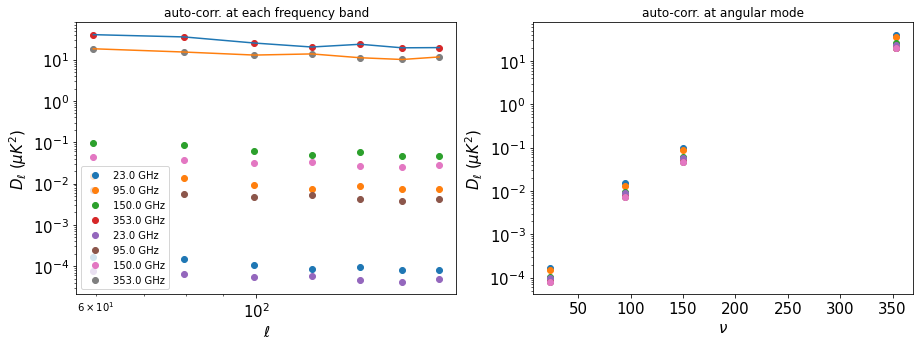

In [8]:
est.targets = 'EB'

fullps = {353:np.array(est.autoBP(map353f,fwhms=FWHM[3])[1:3]).reshape(2,-1)}

d = tdustmodel(freqlist=FREQS,estimator=est,template_ps=fullps)

d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[353][0])
ax[0].plot(est.modes,fullps[353][1])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

E & B modes, modeled

{'A_dE': 2000, 'A_dB': 1000, 'alpha_d': -1.0, 'beta_d': 1.5}


Text(0.5, 1.0, 'auto-corr. at angular mode')

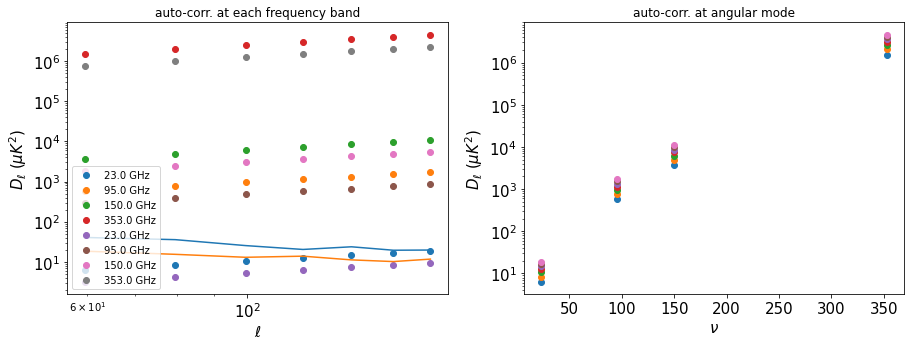

In [9]:
d = adustmodel(freqlist=FREQS,estimator=est)
d.reset({'A_dE':2000})
d.reset({'A_dB':1000})
d.reset({'alpha_d':-1.})
d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,fullps[353][0])
ax[0].plot(est.modes,fullps[353][1])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

#### synchrotron-dust correlated

- T mode, templated

{'beta_d': 1.5, 'beta_s': -3, 'rho': 0.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

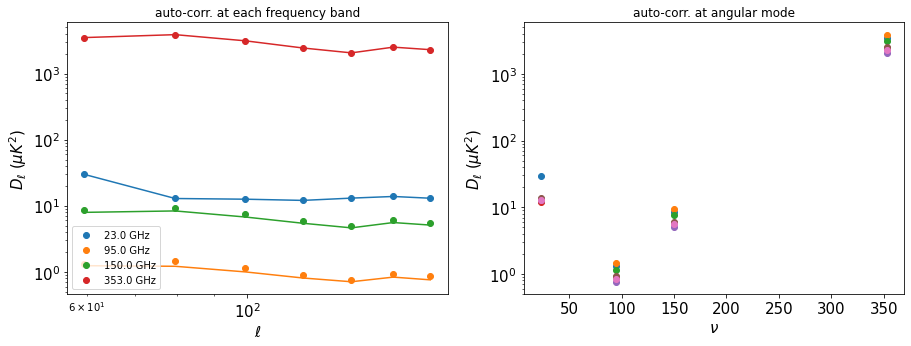

In [10]:
from afra.tools.fg_models import asyncadustmodel, tsynctdustmodel

est.targets = 'T'

fullps = {23:est.autoBP(map23f,fwhms=FWHM[0])[1].reshape(1,-1),
          353:est.autoBP(map353f,fwhms=FWHM[3])[1].reshape(1,-1)}

c = tsynctdustmodel(freqlist=FREQS,estimator=est,
                  template_ps=fullps)
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

fiducial_dl = est.autoBP(map23f,fwhms=FWHM[0])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map95f,fwhms=FWHM[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map150f,fwhms=FWHM[2])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map353f,fwhms=FWHM[3])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

T mode, modeled

{'A_dT': 2000.0, 'A_sT': 2000.0, 'alpha_d': 0.0, 'alpha_s': -1.0, 'beta_d': 1.5, 'beta_s': -3, 'rho': 0.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

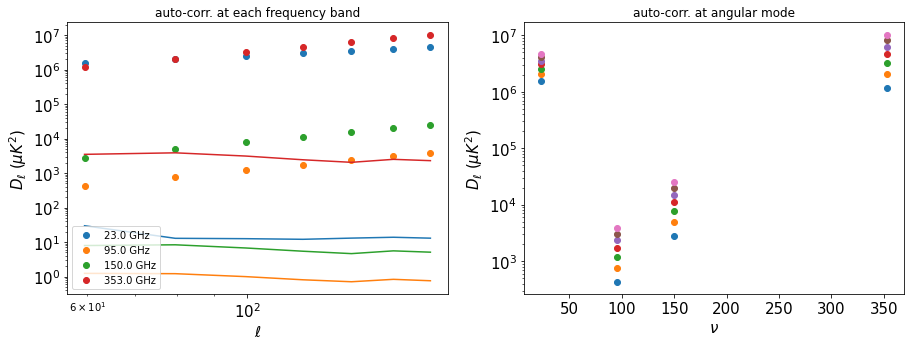

In [11]:
c = asyncadustmodel(freqlist=FREQS,estimator=est)
c.reset({'A_sT':2000.})
c.reset({'A_dT':2000.})
c.reset({'alpha_s':-1.})
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

fiducial_dl = est.autoBP(map23f,fwhms=FWHM[0])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map95f,fwhms=FWHM[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map150f,fwhms=FWHM[2])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = est.autoBP(map353f,fwhms=FWHM[3])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

- E & B modes, templated

{'beta_d': 1.5, 'beta_s': -3, 'rho': 0.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

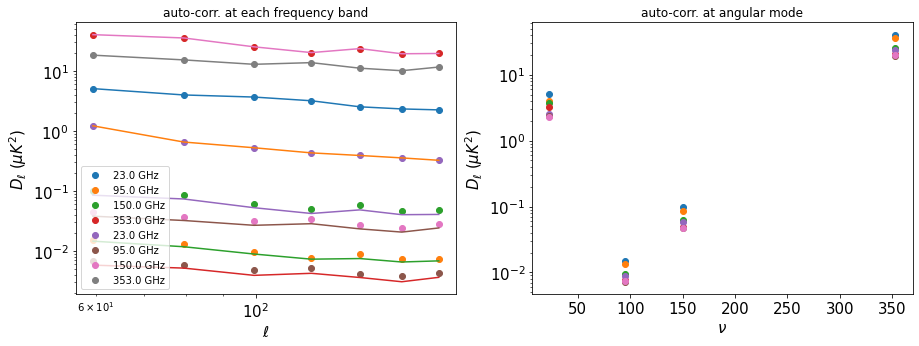

In [12]:
est.targets = 'EB'

fullps = {23:np.array(est.autoBP(map23f,fwhms=FWHM[0])[1:3]).reshape(2,-1),
          353:np.array(est.autoBP(map353f,fwhms=FWHM[3])[1:3]).reshape(2,-1)}

c = tsynctdustmodel(freqlist=FREQS,estimator=est,template_ps=fullps)
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

fiducial_dl = est.autoBP(map23f,fwhms=FWHM[0])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map95f,fwhms=FWHM[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map150f,fwhms=FWHM[2])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map353f,fwhms=FWHM[3])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

E & B modes, modeled

{'A_dE': 2000, 'A_sE': 2000, 'A_dB': 1000, 'A_sB': 1000, 'alpha_d': -2, 'alpha_s': -1, 'beta_d': 1.5, 'beta_s': -3, 'rho': 0.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

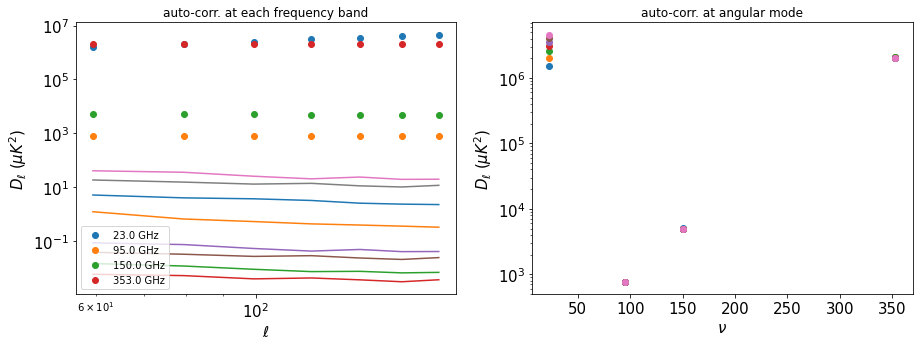

In [13]:
c = asyncadustmodel(freqlist=FREQS,estimator=est)
c.reset({'A_sE':2000})
c.reset({'A_sB':1000})
c.reset({'A_dE':2000})
c.reset({'A_dB':1000})
c.reset({'alpha_s':-1})
c.reset({'alpha_d':-2})
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

fiducial_dl = est.autoBP(map23f,fwhms=FWHM[0])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map95f,fwhms=FWHM[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map150f,fwhms=FWHM[2])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])
fiducial_dl = est.autoBP(map353f,fwhms=FWHM[3])
ax[0].plot(fiducial_dl[0],fiducial_dl[1])
ax[0].plot(fiducial_dl[0],fiducial_dl[2])

for t in range(len(TARGET)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(TARGET)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

#### non-parametric CMB model

- T mode


 param values {'bp_c_T_59.50': 5000.0, 'bp_c_T_79.50': 5000.0, 'bp_c_T_99.50': 5000.0, 'bp_c_T_119.50': 5000.0, 'bp_c_T_139.50': 5000.0, 'bp_c_T_159.50': 5000.0, 'bp_c_T_179.50': 5000.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

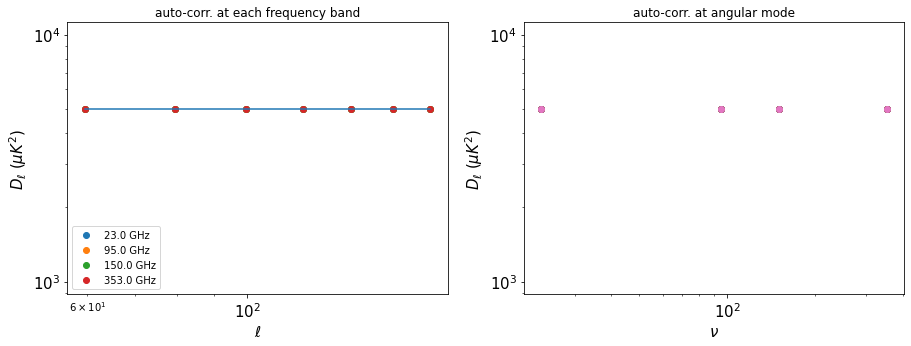

In [14]:
from afra.tools.bg_models import ncmbmodel

est.targets = 'T'

b = ncmbmodel(freqlist=FREQS,estimator=est)

bp = b.bandpower()
print ('\n param values', b.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,[0.5e+4]*len(est.modes))

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

- B mode


 param values {'bp_c_E_59.50': 5000.0, 'bp_c_E_79.50': 5000.0, 'bp_c_E_99.50': 5000.0, 'bp_c_E_119.50': 5000.0, 'bp_c_E_139.50': 5000.0, 'bp_c_E_159.50': 5000.0, 'bp_c_E_179.50': 5000.0, 'bp_c_B_59.50': 5000.0, 'bp_c_B_79.50': 5000.0, 'bp_c_B_99.50': 5000.0, 'bp_c_B_119.50': 5000.0, 'bp_c_B_139.50': 5000.0, 'bp_c_B_159.50': 5000.0, 'bp_c_B_179.50': 5000.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

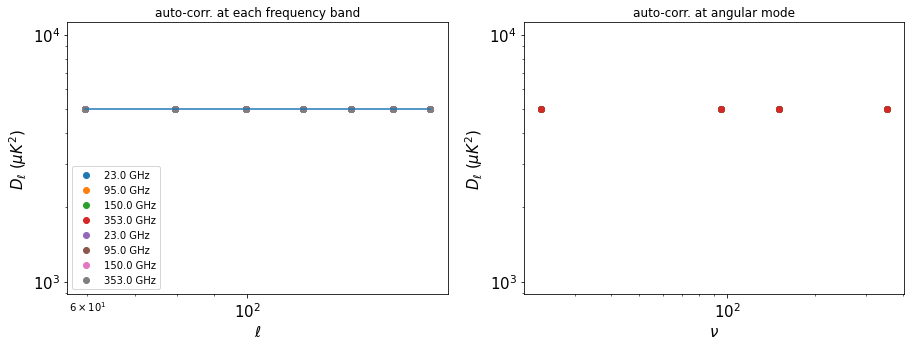

In [15]:
est.targets = 'EB'

b = ncmbmodel(freqlist=FREQS,estimator=est)

bp = b.bandpower()
print ('\n param values', b.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,[0.5e+4]*len(est.modes))

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=3)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(est.targets)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

#### parametric CMB model

- E & B modes


 param values {'r': 0.05, 'Al': 1.0, 'Ae': 1.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

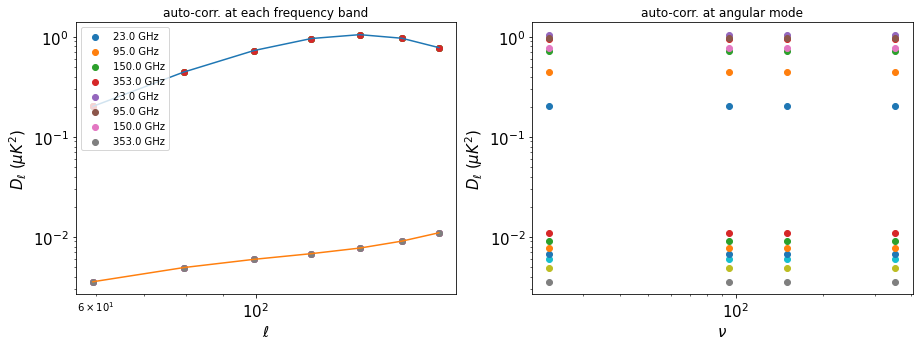

In [16]:
from afra.tools.bg_models import acmbmodel

est.targets = 'EB'

cmb_cl = hp.read_cl('./data/camb_cls.fits')
cmb_dl = np.zeros((4,len(est.modes)))
cmb_dl[0] = est.modes
for i in range(len(est.modes)):
    lrange = np.array(est._b.get_ell_list(i))
    factor = 0.5*lrange*(lrange+1)/np.pi
    w = np.array(est._b.get_weight_list(i))
    for j in range(3):
        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

b = acmbmodel(freqlist=FREQS,estimator=est)

bp = b.bandpower()
print ('\n param values', b.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(cmb_dl[0],cmb_dl[2])
ax[0].plot(cmb_dl[0],cmb_dl[3])

for t in range(len(est.targets)):
    for j in range(len(FREQS)):
        ax[0].scatter(est.modes,bp[t,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=2)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for t in range(len(est.targets)):
    for i in range(len(est.modes)):
        ax[1].scatter(FREQS,np.diag(bp[t,i]))
    
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

#### unlensed B mode


 param values {'r': 0.05, 'Al': 0.0, 'Ae': 1.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

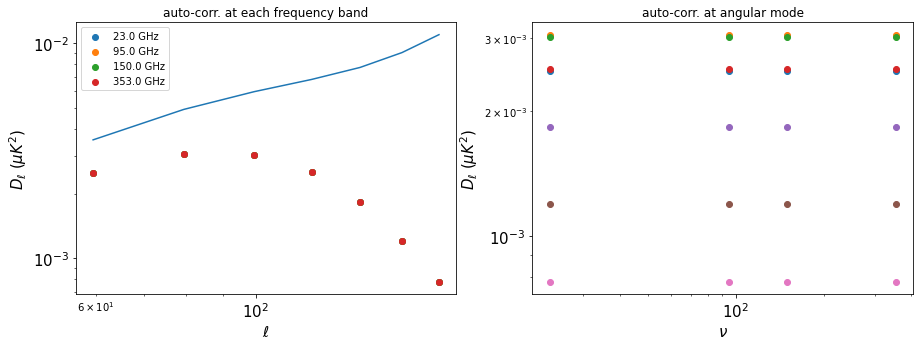

In [17]:
est.targets = 'B'

b = acmbmodel(freqlist=FREQS,estimator=est)
b.reset({'Al':0.})
bp = b.bandpower()
print ('\n param values', b.params)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(cmb_dl[0],cmb_dl[3])

for j in range(len(FREQS)):
    ax[0].scatter(est.modes,bp[0,:,j,j],label=str(FREQS[j])+' GHz')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend(loc=2)
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title('auto-corr. at each frequency band')

for i in range(len(est.modes)):
    ax[1].scatter(FREQS,np.diag(bp[0,i]))
    
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$\nu$',fontsize=15)
ax[1].set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title('auto-corr. at angular mode')

end